# Importing dependencies and dataset

In [2]:
#import model building libraries
import numpy as np
import tensorflow as tf
import os as os
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.regularizers import l2


# Model Building

In [22]:
from tensorflow.keras.models import Model

@tf.keras.utils.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load the VGG16 model, excluding the top dense layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Unfreeze the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
# Define the input
inputs = Input(shape=(64, 64, 3))

# Pass the input through the VGG16 base model
x = base_model(inputs, training=False)

# Add new layers for fine-tuning
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', rmse])

# Early stopping, learning rate reduction, and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('updated_model_vgg16.keras', monitor='val_loss', save_best_only=True)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have directories 'dataset/training_set' and 'dataset/test_set'
train_generator = train_datagen.flow_from_directory(
    'animal-dataset/dataset/Training',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    'animal-dataset/dataset/Testing',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=250,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Found 1526 images belonging to 5 classes.
Found 407 images belonging to 5 classes.
Epoch 1/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 482ms/step - accuracy: 0.2317 - loss: 7.8476 - rmse: 0.4177 - val_accuracy: 0.1990 - val_loss: 6.8910 - val_rmse: 0.3992 - learning_rate: 1.0000e-04
Epoch 2/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 479ms/step - accuracy: 0.2688 - loss: 6.6592 - rmse: 0.3979 - val_accuracy: 0.2482 - val_loss: 6.0025 - val_rmse: 0.3953 - learning_rate: 1.0000e-04
Epoch 3/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - accuracy: 0.2518 - loss: 5.8678 - rmse: 0.3994 - val_accuracy: 0.2187 - val_loss: 5.3417 - val_rmse: 0.3987 - learning_rate: 1.0000e-04
Epoch 4/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 463ms/step - accuracy: 0.2579 - loss: 5.1854 - rmse: 0.3981 - val_accuracy: 0.2162 - val_loss: 4.7388 - val_rmse: 0.3957 - learning_rate: 1.0000e-04
Epoch 5/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 473ms/step - accuracy: 0.2459 - loss: 4.6135 - rmse: 0.3959 - val_accuracy: 0.2580 - val_loss: 4.2338 - va

Epoch 37/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - accuracy: 0.8824 - loss: 0.6247 - rmse: 0.1808 - val_accuracy: 0.8968 - val_loss: 0.6929 - val_rmse: 0.1654 - learning_rate: 1.0000e-04
Epoch 38/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.8853 - loss: 0.6023 - rmse: 0.1783 - val_accuracy: 0.8157 - val_loss: 0.9304 - val_rmse: 0.2315 - learning_rate: 1.0000e-04
Epoch 39/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.9275 - loss: 0.5001 - rmse: 0.1458 - val_accuracy: 0.8034 - val_loss: 1.0075 - val_rmse: 0.2362 - learning_rate: 1.0000e-04
Epoch 40/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.9138 - loss: 0.5270 - rmse: 0.1604 - val_accuracy: 0.9165 - val_loss: 0.5674 - val_rmse: 0.1538 - learning_rate: 1.0000e-04
Epoch 41/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.9169 - loss: 0.5266 - rmse: 0.1593 - val_accuracy: 0.8673 - val_loss: 0.7718 - val_rmse: 0.1999 - learning_rate: 1.0000e-04
Epoch 42/250
48/48 ━━━━━━━━━━━━━━━━

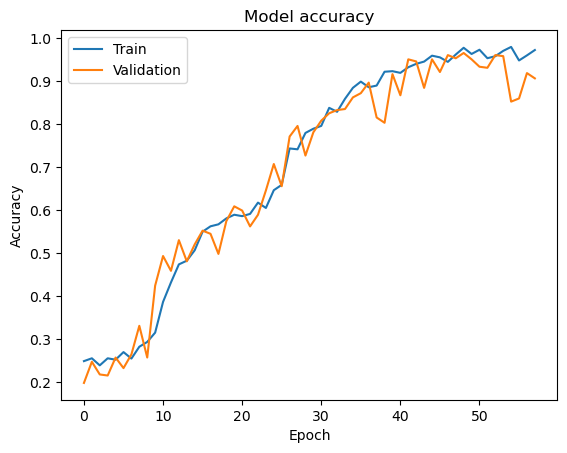

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



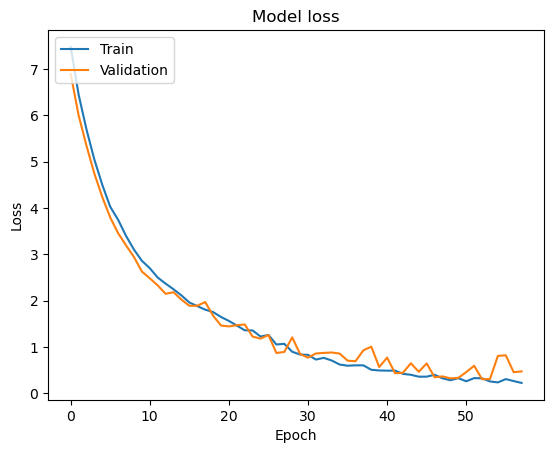

In [24]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


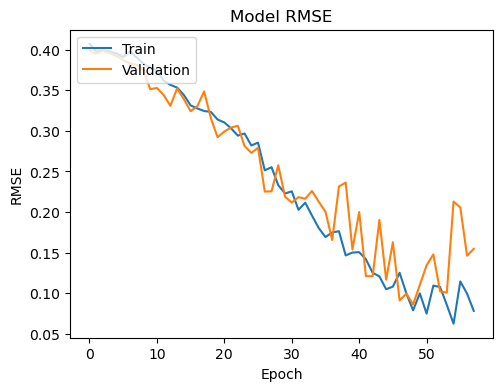

In [25]:
# Plot training & validation RMSE values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [26]:
# Save our model
model.save("updated_vgg16.keras")

# Tesing the Model


In [27]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

import numpy as np

# Load the model
model = load_model("updated_vgg16.keras", custom_objects={'rmse': rmse})

# Assuming you have defined your data generators earlier
# train_generator and validation_generator

# Get class indices
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(class_indices)
print(class_names)
# Function to preprocess the image and make predictions
def predict_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(64, 64))
    
    # Preprocess the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0  # Rescale the image as you did during training

    # Make a prediction
    pred = model.predict(x)
    predicted_class_index = np.argmax(pred)

    # Map predicted index to class name
    class_name = class_names[predicted_class_index]
    
    print("Predicted class index:", predicted_class_index)
    print("Predicted class:", class_name)

{'bears': 0, 'cats': 1, 'crows': 2, 'elephants': 3, 'rats': 4}
['bears', 'cats', 'crows', 'elephants', 'rats']


In [28]:
print("\nElephants: \n")

predict_image("test/elephant1.jpeg")
predict_image("test/elephant2.jpg")
predict_image("test/elephant3.jpeg")
predict_image("test/elephant4.jpeg")
predict_image("test/elephant5.jpeg")
predict_image("test/elephant6.jpeg")


print("\nBears: \n")
predict_image("test/bear1.jpg")
predict_image("test/bear2.jpeg")
predict_image("test/bear3.jpg")
predict_image("test/bear4.jpeg")
predict_image("test/bear5.jpeg")

print("\nCrows: \n")

predict_image("test/crow1.jpg")
predict_image("test/crow2.jpg")
predict_image("test/crow3.jpg")
predict_image("test/crow4.jpg")
predict_image("test/crow5.jpg")

print("\nRats: \n")

predict_image("test/rat1.jpeg")
predict_image("test/rat2.jpeg")
predict_image("test/rat3.jpeg")
predict_image("test/rat4.jpeg")
predict_image("test/rat5.jpeg")

print("\nCats: \n")

predict_image("test/cat1.jpg")
predict_image("test/cat2.jpg")
predict_image("test/cat3.jpg")
predict_image("test/cat4.jpg")
predict_image("test/cat5.jpg")










Elephants: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted class index: 3
Predicted class: elephants
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 3
Predicted class: elephants
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class index: 3
Predicted class: elephants
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 3
Predicted class: elephants
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 3
Predicted class: elephants
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 3
Predicted class: elephants

Bears: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 0
Predicted class: bears
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 0
Predicted class: bears
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class index: 0
Predicted class: bears
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class index: 0
Predicted class: bears
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class index: 0
Predicted class: bears

Crow